In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import numpy as np
from imblearn.over_sampling import RandomOverSampler


In [3]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) SMLlab1IJ_part1
	 (2) scalable1

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/203927
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()

feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/203927/fs/203846/fv/wine/version/1


In [6]:
feature_df, label_df = feature_view.training_data(
    description = 'training dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (1.34s) 


In the dataset some classes have much less samples than others and therefore the training is very imbalanced. To eliminate this balance and train a more accurate model we can over sample some classes.

In [7]:
x = feature_df
y = label_df
ros = RandomOverSampler(random_state=0)

x,y = ros.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)


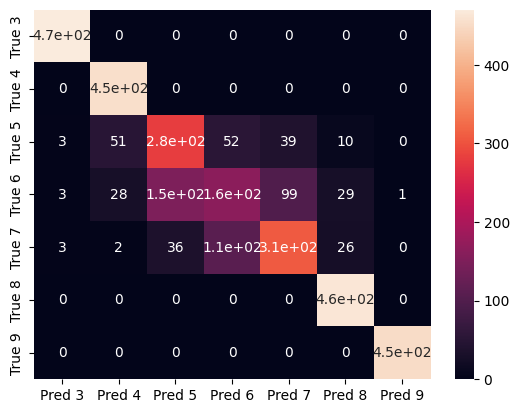

In [14]:
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train.values.ravel())

# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

# Create the confusion matrix as a figure, we will later store it as a PNG image file
true_annotations = [f'True {q}' for q in np.unique(y_test)]
pred_annotations = [f'Pred {q}' for q in np.unique(y_test)]
df_cm = pd.DataFrame(results, true_annotations, pred_annotations)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

The K-Nearest neighbours classifier does not provide the best results, so we can train for example a random forest instead. 

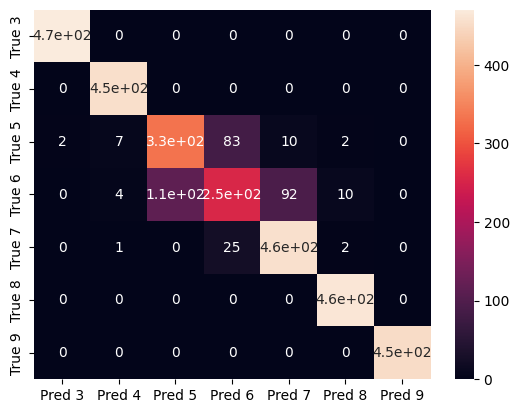

In [16]:
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

# Create the confusion matrix as a figure, we will later store it as a PNG image file
true_annotations = [f'True {q}' for q in np.unique(y_test)]
pred_annotations = [f'Pred {q}' for q in np.unique(y_test)]
df_cm = pd.DataFrame(results, true_annotations, pred_annotations)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [30]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.8910891089108911

In [31]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/203927/models/wine_model/1


Model(name: 'wine_model', version: 1)